# Turn-by-turn bunch analysis

In [1]:
import os
import pickle
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proplot as pplt
from ipywidgets import interact
from ipywidgets import widgets

sys.path.append("/home/46h/repo/psdist/")
import psdist as ps
import psdist.visualization as psv

from tunes import compute_tunes_phase_diff

In [2]:
pplt.rc["colorbar.width"] = "1.2em"
pplt.rc["cmap.discrete"] = False
pplt.rc["cmap.sequential"] = "viridis"
pplt.rc["cycle"] = "538"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["grid"] = False

## Load data 

In [4]:
timestamp = 230921141718
datadir = f"../../data_output/sns_ring/track_bunch/{timestamp}"
os.listdir(datadir)

['track_bunch.py',
 'log.txt',
 'lattice_params.pkl',
 'lattice_twiss.dat',
 'lattice_dispersion.dat',
 'lattice_params_4d.pkl',
 'lattice_twiss_4d.dat',
 'history.dat',
 'smallbunch_00000.npy',
 'smallbunch_00001.npy',
 'smallbunch_00002.npy',
 'smallbunch_00003.npy',
 'smallbunch_00004.npy',
 'smallbunch_00005.npy',
 'smallbunch_00006.npy',
 'smallbunch_00007.npy',
 'smallbunch_00008.npy',
 'smallbunch_00009.npy',
 'smallbunch_00010.npy',
 'smallbunch_00011.npy',
 'smallbunch_00012.npy',
 'smallbunch_00013.npy',
 'smallbunch_00014.npy',
 'smallbunch_00015.npy',
 'smallbunch_00016.npy',
 'smallbunch_00017.npy',
 'smallbunch_00018.npy',
 'smallbunch_00019.npy',
 'smallbunch_00020.npy',
 'smallbunch_00021.npy',
 'smallbunch_00022.npy',
 'smallbunch_00023.npy',
 'smallbunch_00024.npy',
 'smallbunch_00025.npy',
 'smallbunch_00026.npy',
 'smallbunch_00027.npy',
 'smallbunch_00028.npy',
 'smallbunch_00029.npy',
 'smallbunch_00030.npy',
 'smallbunch_00031.npy',
 'smallbunch_00032.npy',
 'sma

## Linear lattice analysis 

### Transfer matrix

In [7]:
file = open(os.path.join(datadir, "lattice_params_4d.pkl"), "rb")
lattice_params_4d = pickle.load(file, encoding="latin1")
file.close()

pprint(lattice_params_4d)

{'M': array([[ 5.14920817e-01,  1.11482410e+01,  1.43310082e-02,
         3.90576372e-01,  0.00000000e+00, -1.08153045e-01,
         0.00000000e+00],
       [-7.21237690e-02,  3.69771363e-01, -7.88608929e-03,
         1.71917435e-01,  0.00000000e+00, -5.04788326e-03,
         0.00000000e+00],
       [-8.70195983e-02, -1.83949217e+00,  4.58743538e-01,
         1.09030532e+01,  0.00000000e+00,  4.44946724e-03,
         0.00000000e+00],
       [ 7.28985164e-03,  9.03906115e-02, -7.32165819e-02,
         4.27628561e-01,  0.00000000e+00,  2.94296116e-06,
         0.00000000e+00],
       [ 1.28507685e-02,  2.05599384e-02,  7.36776351e-04,
        -1.81707708e-02,  1.00000000e+00,  5.12820225e+01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.0

### Position-dependent parameters

These might be wrong.

In [8]:
filename = os.path.join(datadir, "lattice_twiss_4d.dat")
twiss_4d = pd.read_table(filename, sep=" ", index_col=0)
twiss_4d.head()

,s,beta_1x,beta_1y,beta_2x,beta_2y,alpha_1x,alpha_1y,alpha_2x,alpha_2y,u,nu1,nu2
0,0.000000,1.566787,6.672547,6.652847,1.149864,0.241296,0.014828,0.002076,-0.203434,0.900497,-3.141593,-0.000000
1,0.883004,1.491677,6.675362,6.678243,1.220815,0.228533,-0.018016,-0.030837,0.216318,0.887611,-3.141593,-3.141593
2,1.378195,1.454384,6.702325,6.713864,1.267727,0.223069,-0.036435,-0.041967,-0.223829,0.883489,-3.141593,-0.000000
3,1.873387,1.419711,6.747531,6.761344,1.319654,-0.217439,-0.054854,-0.053900,0.231502,0.879243,-0.000000,-3.141593
4,2.963570,1.362668,6.911341,6.953526,1.452101,-0.199702,-0.095405,-0.108504,-0.248841,0.860369,-0.000000,-0.000000


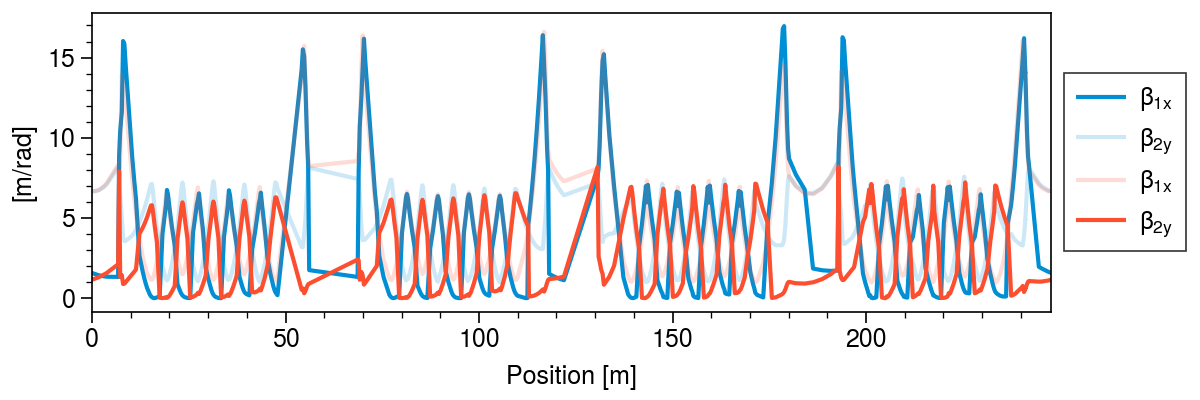

In [9]:
fig, ax = pplt.subplots(figsize=(6, 2))
_colors = pplt.Cycle("538").by_key()["color"]
ax.plot(twiss_4d["s"], twiss_4d["beta_1x"], label=r"$\beta_{1x}$", color=_colors[0])
ax.plot(twiss_4d["s"], twiss_4d["beta_1y"], label=r"$\beta_{2y}$", color=_colors[0], alpha=0.2)
ax.plot(twiss_4d["s"], twiss_4d["beta_2x"], label=r"$\beta_{1x}$", color=_colors[1], alpha=0.2)
ax.plot(twiss_4d["s"], twiss_4d["beta_2y"], label=r"$\beta_{2y}$", color=_colors[1])
ax.legend(loc="right", ncols=1)
ax.format(xlabel="Position [m]", ylabel="[m/rad]")
plt.show()

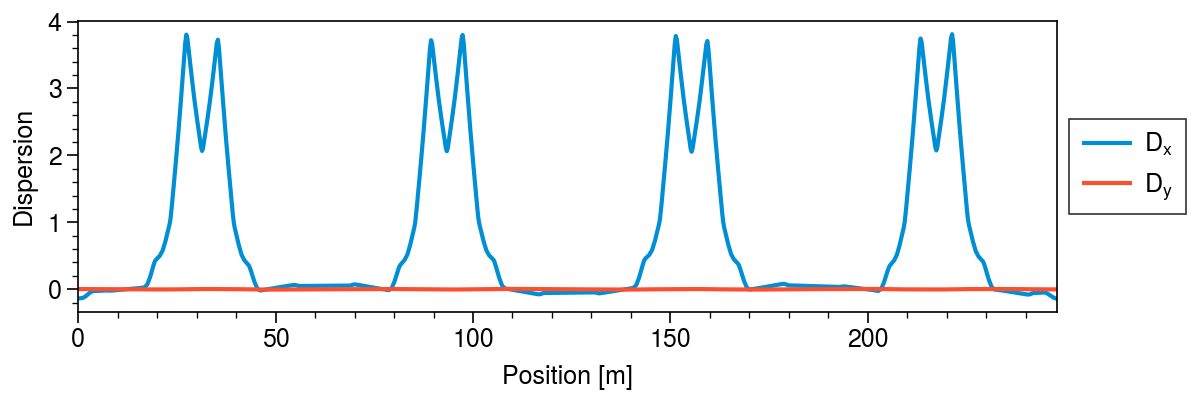

In [10]:
filename = os.path.join(datadir, "lattice_dispersion.dat")
dispersion = pd.read_table(filename, sep=" ", index_col=0)

fig, ax = pplt.subplots(figsize=(6, 2))
ax.plot(dispersion["s"], dispersion["disp_x"], label=r"$D_x$")
ax.plot(dispersion["s"], dispersion["disp_y"], label=r"$D_y$")
ax.legend(loc="right", ncols=1)
ax.format(xlabel="Position [m]", ylabel="Dispersion")
plt.show()

## Scalar history 

In [11]:
history = pd.read_csv(os.path.join(datadir, "history.dat"))
history.columns

Index(['eps_x', 'y_rms', 'cov_1-1', 'energy', 'cov_1-3', 'cov_1-4', 'cov_3-3',
       'eps_y', 'n_parts', 'z_rms', 'cov_3-4', 'cov_0-5', 'cov_4-5', 'cov_0-4',
       'z_max', 'cov_1-5', 'cov_5-5', 'cov_1-2', 'cov_0-0', 'cov_3-5', 'y_min',
       'eps_2', 'cov_2-5', 'eps_1', 'x_rms', 'cov_4-4', 'x_min', 'z_min',
       'x_max', 'cov_2-4', 'y_max', 'beta', 'cov_2-3', 'cov_2-2', 'cov_0-1',
       'gamma', 'cov_0-3', 'cov_0-2', 'mean_4', 'mean_5', 'mean_0', 'mean_1',
       'mean_2', 'mean_'],
      dtype='object')

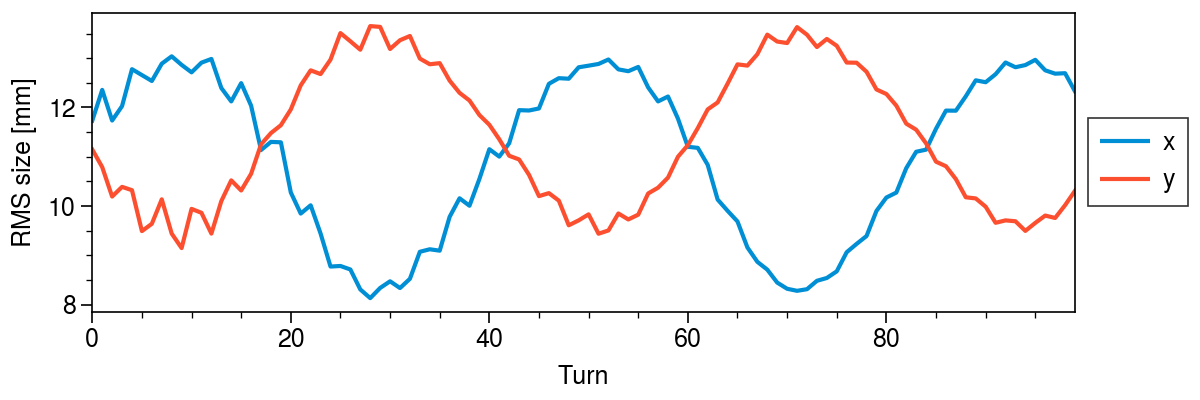

In [12]:
fig, ax = pplt.subplots(figsize=(6, 2))
ax.plot(1000.0 * history.loc[:, "x_rms"].values, label="x")
ax.plot(1000.0 * history.loc[:, "y_rms"].values, label="y")
ax.format(xlabel="Turn", ylabel="RMS size [mm]")
ax.legend(loc="r", ncols=1)
plt.show()

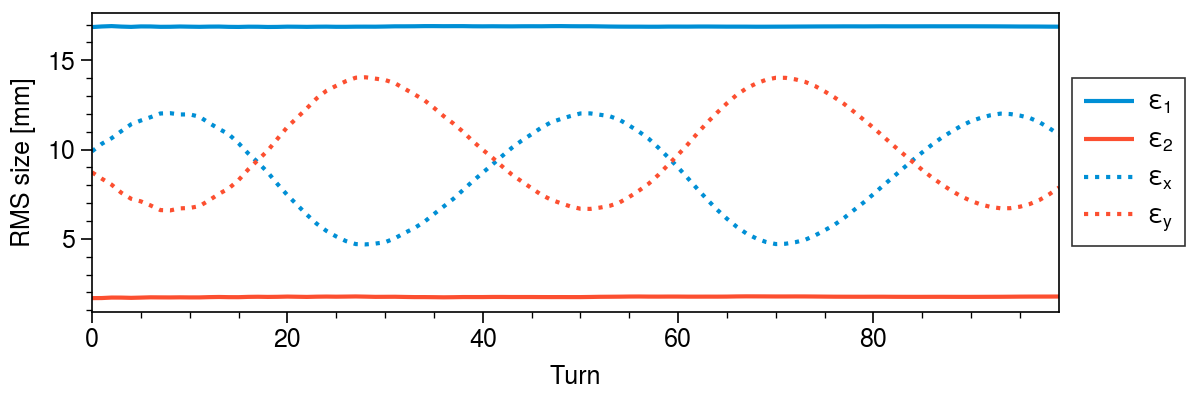

In [13]:
colors = pplt.Cycle("538").by_key()["color"]

fig, ax = pplt.subplots(figsize=(6, 2))
ax.plot(1.00e+06 * history.loc[:, "eps_1"].values, label=r"$\varepsilon_1$", color=colors[0], ls="-")
ax.plot(1.00e+06 * history.loc[:, "eps_2"].values, label=r"$\varepsilon_2$", color=colors[1], ls="-")
ax.plot(1.00e+06 * history.loc[:, "eps_x"].values, label=r"$\varepsilon_x$", color=colors[0], ls=":")
ax.plot(1.00e+06 * history.loc[:, "eps_y"].values, label=r"$\varepsilon_y$", color=colors[1], ls=":")
ax.format(xlabel="Turn", ylabel="RMS size [mm]")
ax.legend(loc="r", ncols=1)
plt.show()

## Small bunch

In [14]:
filenames = os.listdir(datadir)
filenames = [f for f in filenames if f.startswith("smallbunch")]
filenames = sorted(filenames)
filenames = [os.path.join(datadir, f) for f in filenames]
filenames[:10]

['../../data_output/sns_ring/track_bunch/230921141718/smallbunch_00000.npy',
 '../../data_output/sns_ring/track_bunch/230921141718/smallbunch_00001.npy',
 '../../data_output/sns_ring/track_bunch/230921141718/smallbunch_00002.npy',
 '../../data_output/sns_ring/track_bunch/230921141718/smallbunch_00003.npy',
 '../../data_output/sns_ring/track_bunch/230921141718/smallbunch_00004.npy',
 '../../data_output/sns_ring/track_bunch/230921141718/smallbunch_00005.npy',
 '../../data_output/sns_ring/track_bunch/230921141718/smallbunch_00006.npy',
 '../../data_output/sns_ring/track_bunch/230921141718/smallbunch_00007.npy',
 '../../data_output/sns_ring/track_bunch/230921141718/smallbunch_00008.npy',
 '../../data_output/sns_ring/track_bunch/230921141718/smallbunch_00009.npy']

In [15]:
smallbunches = []
for filename in filenames:
    X = np.load(filename)
    X[:, :4] *= 1000.0  # [m, rad] -> [mm, mrad]
    X[:, 5] *= 1000.0  # [GeV] -> [MeV]
    smallbunches.append(X)
smallbunches = np.array(smallbunches)
smallbunches.shape

(100, 10000, 6)

In [16]:
widget = psv.cloud.proj2d_interactive_slice(
    data=list(smallbunches),
    dims=["x", "px", "y", "py", "z", "pz"],
    share_limits=2,
    options=dict(ellipse=True),
    rms_ellipse_kws=dict(color="black", level=2.0),
    cmap=pplt.Colormap("mono", left=0.05, right=0.85),
)
display(widget)

interactive(children=(BoundedIntText(value=0, description='frame', max=99), Dropdown(description='dim 1', opti…

### Tunes

Normalize the bunch coordinates using the lattice Twiss parameters. Ignore dispersion.

In [20]:
V = np.copy(lattice_params_4d["V"])
Vinv = np.linalg.inv(V)

smallbunches_n = np.zeros(smallbunches.shape)
for i in range(smallbunches_n.shape[0]):
    smallbunches_n[i, :, :4] = ps.cloud.transform_linear(smallbunches[i, :, :4], Vinv)

In [21]:
widget = psv.cloud.proj2d_interactive_slice(
    data=list(smallbunches_n[:, :, :4]),
    dims=["x_n", "px_n", "y_n", "py_n"],
    share_limits=2,
    options=dict(ellipse=True),
    rms_ellipse_kws=dict(color="black", level=2.0),
    cmap=pplt.Colormap("mono", left=0.05, right=0.85),
)
display(widget)

interactive(children=(BoundedIntText(value=0, description='frame', max=99), Dropdown(description='dim 1', opti…

In [32]:
tunes = compute_tunes_phase_diff(smallbunches_n[:3])

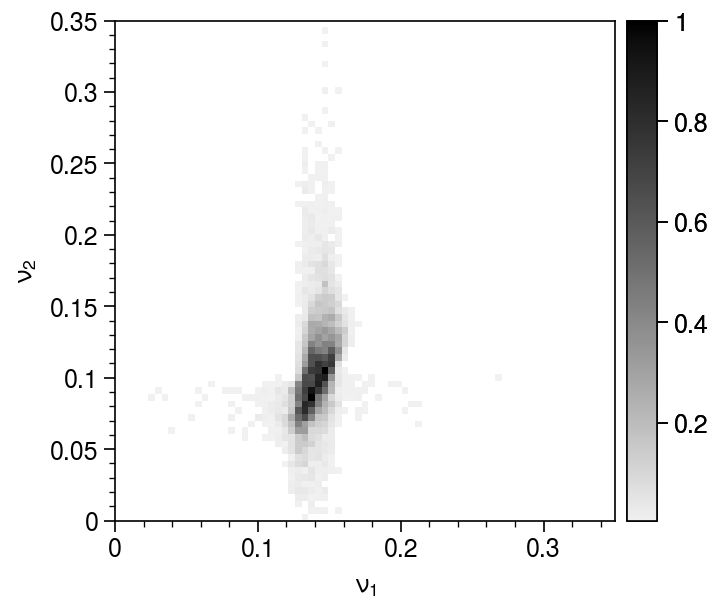

In [33]:
xmin = 0.0
xmax = 0.35
ymin = 0.0
ymax = 0.35
limits = [(xmin, xmax), (ymin, ymax)]

fig, ax = pplt.subplots()
psv.cloud.plot2d(
    tunes,
    ax=ax,
    # kind="scatter",
    bins=75,
    limits=limits,
    process_kws=dict(norm="max"),
    cmap=pplt.Colormap("mono", left=0.05, right=1.0),
    colorbar=True,
)
ax.format(xlim=limits[0], ylim=limits[1])
ax.format(xlabel=r"$\nu_1$", ylabel=r"$\nu_2$")
plt.show()

In [37]:
import scipy.fft

def fft(x):
    N = len(x)
    M = N // 2
    freq = (1.0 / N) * np.arange(M)
    amp = (1.0 / M) * np.abs(scipy.fft.fft(x)[:M])
    return freq, amp

In [60]:
@interact()
def update(dim=["x", "y"], part=(0, len(smallbunches[0]) - 1)):
    axis = {"x": 0, "y": 2}[dim]
    signal = smallbunches[:, part, axis]
    freq, amp = fft(signal)
    amp = amp / np.max(amp)

    fig, ax = pplt.subplots(figsize=(6, 2))
    ax.plot(freq[1:], amp[1:], color="black")
    ax.format(xlabel="Freqency", ylabel="Amplitude")
    ax.format(xlim=(0.0, 0.5), ylim=(-0.02, 1.1))
    plt.show()

interactive(children=(Dropdown(description='dim', options=('x', 'y'), value='x'), IntSlider(value=4999, descri…